In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F


# hyperparameters
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ------------

torch.manual_seed(1337)

In [2]:

with open("../data/tinyshakespeare/input.txt") as f:
    text = f.read()

In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("".join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [4]:
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join(itos[i] for i in l)
print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [5]:
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000])

torch.Size([1115393]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [6]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

In [7]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [8]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context}, the target: {target}")

when input is tensor([18]), the target: 47
when input is tensor([18, 47]), the target: 56
when input is tensor([18, 47, 56]), the target: 57
when input is tensor([18, 47, 56, 57]), the target: 58
when input is tensor([18, 47, 56, 57, 58]), the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]), the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]), the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]), the target: 58


In [9]:
def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size, ))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    
    return x, y

In [10]:
xb, yb = get_batch('train')

In [11]:
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"when input is {context.tolist()}, the target: {target}")

when input is [53], the target: 59
when input is [53, 59], the target: 6
when input is [53, 59, 6], the target: 1
when input is [53, 59, 6, 1], the target: 58
when input is [53, 59, 6, 1, 58], the target: 56
when input is [53, 59, 6, 1, 58, 56], the target: 47
when input is [53, 59, 6, 1, 58, 56, 47], the target: 40
when input is [53, 59, 6, 1, 58, 56, 47, 40], the target: 59
when input is [49], the target: 43
when input is [49, 43], the target: 43
when input is [49, 43, 43], the target: 54
when input is [49, 43, 43, 54], the target: 1
when input is [49, 43, 43, 54, 1], the target: 47
when input is [49, 43, 43, 54, 1, 47], the target: 58
when input is [49, 43, 43, 54, 1, 47, 58], the target: 1
when input is [49, 43, 43, 54, 1, 47, 58, 1], the target: 58
when input is [13], the target: 52
when input is [13, 52], the target: 45
when input is [13, 52, 45], the target: 43
when input is [13, 52, 45, 43], the target: 50
when input is [13, 52, 45, 43, 50], the target: 53
when input is [13, 52

In [12]:
class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        
    def forward(self, idx, targets=None):
        
        logits = self.token_embedding_table(idx)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        
        for _ in range(max_new_tokens):
            
            logits, loss = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=1)
            
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
            
        return idx
    
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)


In [52]:
import matplotlib.pyplot as plt

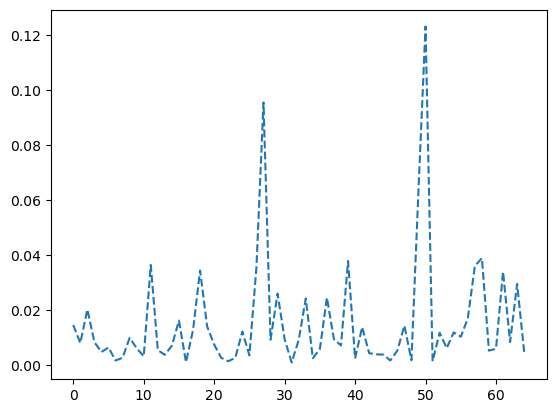

In [60]:
plt.close("all")
plt.plot(F.softmax(m(torch.tensor([[0]], dtype=torch.long))[0][:, -1, :], dim=1).detach()[0], ls="--")

In [69]:
torch.multinomial(F.softmax(m(torch.tensor([[0]], dtype=torch.long))[0][:, -1, :], dim=1), num_samples=1)

tensor([[55]])

In [14]:
print(m.generate(torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist())

[0, 2, 24, 64, 52, 21, 43, 22, 63, 42, 38, 22, 31, 56, 18, 31, 56, 28, 24, 30, 2, 10, 34, 61, 35, 31, 51, 18, 26, 62, 40, 48, 28, 47, 26, 37, 29, 10, 57, 56, 63, 6, 27, 44, 23, 56, 62, 44, 60, 22, 21, 3, 35, 31, 9, 22, 55, 15, 40, 14, 7, 32, 31, 29, 36, 43, 23, 56, 53, 43, 38, 44, 28, 24, 4, 6, 10, 53, 54, 49, 50, 11, 14, 60, 58, 64, 3, 24, 51, 27, 25, 63, 16, 48, 62, 62, 39, 38, 35, 58, 54]
